In [1]:
import pyart                              
import wradlib as wrl                     
import matplotlib.pyplot as plt           
import matplotlib.ticker as ticker
import cartopy.crs as ccrs                
import numpy as np                        
from netCDF4 import num2date              
import geopy                              
from geopy import distance                
from datetime import datetime, timedelta  

### Ignorando avisos:
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#### IMPORTANTE:
### Caminhos para leitura e gravação de arquivo:
path_radar = '/home/andre/Desktop/PCI-INPE/00-github/Dados_radares_CETEA/SR/'
output = '/home/andre/Desktop/PCI-INPE/00-github/'

### Nome de um arquivo específico:
filename = path_radar+'R13537474_202401312230.hdf5'

### Leitura do arquivo:
radar = pyart.aux_io.read_gamic(filename)

In [3]:
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                           aneis (lista): tamanho do raio do círculo em km
                           lon_r (float): valor da longitude do centro do círculo em graus
                           lat_r (float): valor da latitude do centro do círculo em graus
                           color (str): cor do raio do círculo
                           label (str): legenda

    Parâmetros de saída:
                         latitude e longitude que delimitam os círculos de distância centrado no radar e plota os círculos

    Exemplo:
             evm_plota_aneis_em_geral([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')
    """

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label)

## Conhecendo os dados do radar com o pacote Py-ART:

In [4]:
#### IMPORTANTE: definindo a extensão dos dados em termos de latitude/longitude:
lonmin = radar.gate_longitude['data'].min()
lonmax = radar.gate_longitude['data'].max()
latmin = radar.gate_latitude['data'].min()
latmax = radar.gate_latitude['data'].max()
print(lonmin, lonmax, latmin, latmax)

-49.531784 -44.65682 -25.835459 -21.368536


In [5]:
#-----------------------------------------------------------------------------------
#        Obtêm as informações do radar a partir do dado bruto (HDF5)
#-----------------------------------------------------------------------------------
def get_info_radar(radar):

    """
    Obtêm as informações dos dados do radar

    Parâmetros de entrada:
                           radar (object): objeto do pyart

    Parâmetros de saída:
                         dic (dicionário): informações do radar, como:
                           date_start(list): ano, mês, dia hora, minuto inicial do scan do radar
                           date_end(list): ano, mês, dia hora, minuto final do scan do radar
                           lon_radar(float): longitude do radar em graus
                           lat_radar(float): latitude do radar em graus
                           alt_radar(float): altitude do radar em metros
                           radar_frequency(float): frequência do radar em Hz
                           radar_beam_width(float): largura do feixe em graus
                           nsweeps(int): quantidade de elevações
                           sweeps(list): ângulos de elevação em graus
                           nrays(list): quantidade de azimutes para cada elevação
                           ngates(int): quantidade de bins
                           radial_resolution(float): resolução radial do radar em metros
                           ray_angle_res(float): resolução azimutal em graus
                           lonmin(float): longitude mínima da matriz de dados
                           lonmax(float): longitude máxima da matriz de dados
                           latmin(float): latitude mínima da matriz de dados
                           latmax(float): latitude máxima da matriz de dados
                           variables(list): variáveis disponíveis

    Exemplo:
             dic = get_info_radar(radar)
    """

    # campos disponíveis
    variaveis = radar.fields.keys()

    # latitude e longitude do radar
    lon_radar, lat_radar, alt_radar = radar.longitude['data'][0], radar.latitude['data'][0], radar.altitude['data'][0]

    # informações sobre o tempo
    data_ini = num2date(radar.time['data'][0], radar.time['units'] )
    data_end = num2date(radar.time['data'][-1], radar.time['units'] )

    # extrai o ano, mes dia, hora e minuto inicial da imagem
    anoi, mesi, diai, hori, mini, segi = str(data_ini.year), str(data_ini.month).zfill(2), str(data_ini.day).zfill(2), str(data_ini.hour).zfill(2), str(data_ini.minute).zfill(2), str(data_ini.second).zfill(2)
    anof, mesf, diaf, horf, minf, segf = str(data_end.year), str(data_end.month).zfill(2), str(data_end.day).zfill(2), str(data_end.hour).zfill(2), str(data_end.minute).zfill(2), str(data_end.second).zfill(2)

    # frequência do radar
    radar_frequency = radar.instrument_parameters['frequency']['data'][0]

    # largura do feixe
    radar_beam_width = radar.instrument_parameters['radar_beam_width_h']['data'][0]

    # quantidade TOTAL de bins do feixe
    ngates = radar.ngates

    # quantidade de elevações
    nsweeps = radar.nsweeps

    # quantidade de azimutes por elevação
    total_azimuths = radar.azimuth['data'].shape[0]
    index_azimuths = radar.sweep_start_ray_index['data'].tolist()
    index_azimuths.append(total_azimuths)
    qte_azim = [index_azimuths[i+1] - index_azimuths[i] for i in range(nsweeps)]

    # resolução radial
    radial_resolution = radar.range['meters_between_gates']

    # informação apenas da resolução ângulo azimutal
    ray_angle_res = radar.ray_angle_res['data'][0]

    # ângulos de elevação
    sweeps =  radar.fixed_angle['data']

    # definindo a extensão dos dados em termos de latitude/longitude
    lats = radar.gate_latitude
    lons = radar.gate_longitude
    lonmin = lons['data'].min()
    lonmax = lons['data'].max()
    latmin = lats['data'].min()
    latmax = lats['data'].max()

    # coloca as variáveis num dicionário
    dic = {
            'date_start(year,month,day,hour,minute)': [anoi, mesi, diai, hori, mini],
            'date_end(year,month,day,hour,minute)': [anof, mesf, diaf, horf, minf],
            'lon_radar(degree)': lon_radar,
            'lat_radar(degree)': lat_radar,
            'alt_radar(meters)': alt_radar,
            'radar_frequency(Hz)': radar_frequency,
            'radar_beam_width(degree)': radar_beam_width,
            'nsweeps(#)': nsweeps,
            'sweeps(degree)': list(sweeps),
            'nrays(#)': qte_azim,
            'ngates(#)': ngates,
            'radial_resolution(meters)': radial_resolution,
            'ray_angle_res(degree)': ray_angle_res,
            'lonmin(degree)': lonmin,
            'lonmax(degree)': lonmax,
            'latmin(degree)': latmin,
            'latmax(degree)': latmax,
            'variables': list(variaveis)}
    return dic

In [6]:
### Processa a função que extrai as infomações do dado do radar
dic = get_info_radar(radar)

### Salva um arquivo com todas as informações do radar:
with open(output+'Infos_radar_SR.csv', 'w') as f:
    for key in dic.keys():
        f.write("%s= %s\n"%(key, dic[key]))

## Plotando a estratégia de varredura do radar:

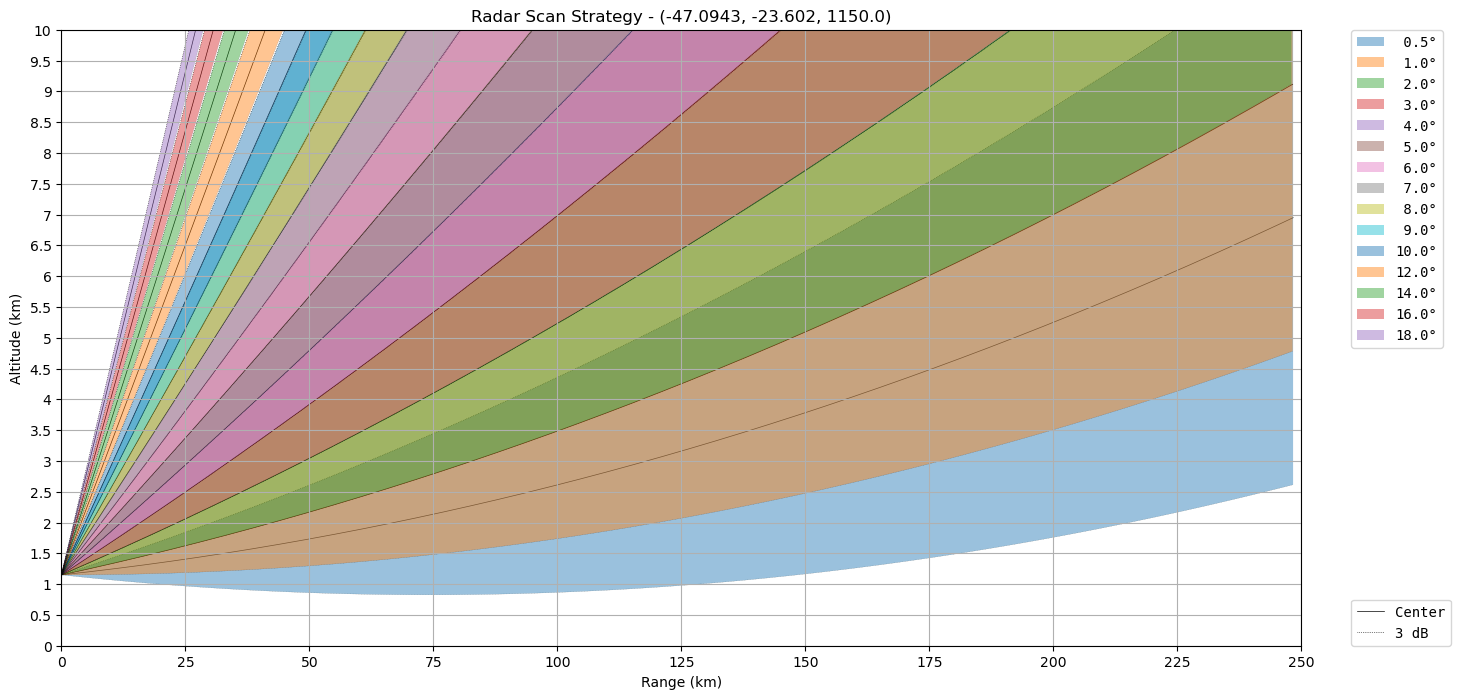

In [7]:
### Distância de cada bin ao radar em metros:
ranges = np.arange(dic['ngates(#)']) * dic['radial_resolution(meters)']

### Coordenadas do radar (longitude, latitude, altitude):
sitecoords = (dic['lon_radar(degree)'], dic['lat_radar(degree)'], dic['alt_radar(meters)'])

### Plota figura de estratégia de varredura do radar com o pacote wradlib:
wrl.vis.plot_scan_strategy(ranges, dic['sweeps(degree)'], sitecoords, 
                           beamwidth=dic['radar_beam_width(degree)'],
                           maxrange=250000.0, units='km')

plt.savefig(output+'Estrategia_radar_SR.png', dpi=300)

## Gerando e plotando Constant Altitude Plan Position Indicator (CAPPI):

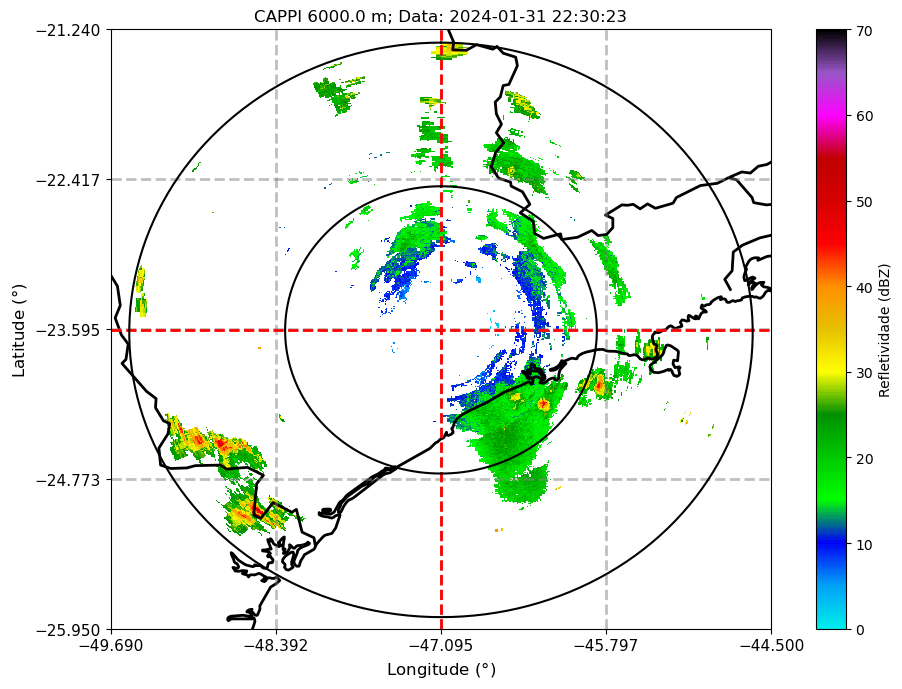

In [8]:
altitude = radar.altitude['data'][0]
data = pyart.util.datetime_from_grid(radar)

#========================================================================================================================#
#                                       GERA O CAPPI a 6 km de altura
#========================================================================================================================#
cappi = pyart.map.grid_from_radars(radar,
                                   grid_shape=(13, 500, 500),
                                   grid_limits=((6000. - dic['alt_radar(meters)'],
                                                 15000. - dic['alt_radar(meters)']),
                                                (-250000., 250000.),
                                                (-250000., 250000.)),
                                   grid_origin=(dic['lat_radar(degree)'], dic['lon_radar(degree)']),
                                   gridding_algo='map_gates_to_grid',
                                   roi_func='dist_beam',
                                   min_radius=1750.0,
                                   weighting_function='Nearest',
                                   fields=['corrected_reflectivity'])

#========================================================================================================================#
#                                                     PLOTA FIGURA
#========================================================================================================================#
tf = 12
fig = plt.figure(figsize=(10,7))

### Define os eixos e projeção da figura:
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=tf-1, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=tf-1, color='black')

### Monta um objeto "display" do Py-ART:
display = pyart.graph.GridMapDisplay(cappi)

### Plota o cappi:
display.plot_grid("corrected_reflectivity",
                  level=0,
                  vmin=0,
                  vmax=70,
                  ax=ax,
                  cmap='pyart_NWSRef',
                  colorbar_label='Refletividade (dBZ)')

### Plota as linhas passando pelo radar:
display.plot_crosshairs(lon=dic['lon_radar(degree)'], lat=dic['lat_radar(degree)'])

### Plota os aneis de distância do radar:
evm_plota_aneis_em_geral([125, 250], dic['lon_radar(degree)'], dic['lat_radar(degree)'], 'black',
                        label='Radar SR')

### Título da figura:
plt.title(f'CAPPI {int(display.grid.z["data"][0]) + altitude} m; Data: {data}', fontsize=tf)

ax.set_xlabel('Longitude ($\degree$)', fontsize=tf)
ax.set_ylabel('Latitude ($\degree$)', fontsize=tf)
plt.tight_layout()

### Salva figura:
plt.savefig(output+f'Exemplo_CAPPI_{data}_SR.png', dpi=300)